# Pneumonia Identification from X-rays

Data available at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810

#### Import the necessary Libraries 

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [16]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8863144228919818339
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3665166336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4424681643232242452
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


##### Print all data directories 

In [13]:
for dirname, _, filenames in os.walk('chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

chest_xray\.DS_Store
chest_xray\test\.DS_Store
chest_xray\test\NORMAL\IM-0001-0001.jpeg
chest_xray\test\NORMAL\IM-0003-0001.jpeg
chest_xray\test\NORMAL\IM-0005-0001.jpeg
chest_xray\test\NORMAL\IM-0006-0001.jpeg
chest_xray\test\NORMAL\IM-0007-0001.jpeg
chest_xray\test\NORMAL\IM-0009-0001.jpeg
chest_xray\test\NORMAL\IM-0010-0001.jpeg
chest_xray\test\NORMAL\IM-0011-0001-0001.jpeg
chest_xray\test\NORMAL\IM-0011-0001-0002.jpeg
chest_xray\test\NORMAL\IM-0011-0001.jpeg
chest_xray\test\NORMAL\IM-0013-0001.jpeg
chest_xray\test\NORMAL\IM-0015-0001.jpeg
chest_xray\test\NORMAL\IM-0016-0001.jpeg
chest_xray\test\NORMAL\IM-0017-0001.jpeg
chest_xray\test\NORMAL\IM-0019-0001.jpeg
chest_xray\test\NORMAL\IM-0021-0001.jpeg
chest_xray\test\NORMAL\IM-0022-0001.jpeg
chest_xray\test\NORMAL\IM-0023-0001.jpeg
chest_xray\test\NORMAL\IM-0025-0001.jpeg
chest_xray\test\NORMAL\IM-0027-0001.jpeg
chest_xray\test\NORMAL\IM-0028-0001.jpeg
chest_xray\test\NORMAL\IM-0029-0001.jpeg
chest_xray\test\NORMAL\IM-0030-0001.jpeg


chest_xray\train\PNEUMONIA\person1325_bacteria_3366.jpeg
chest_xray\train\PNEUMONIA\person1325_virus_2287.jpeg
chest_xray\train\PNEUMONIA\person1326_bacteria_3372.jpeg
chest_xray\train\PNEUMONIA\person1327_bacteria_3373.jpeg
chest_xray\train\PNEUMONIA\person1327_bacteria_3374.jpeg
chest_xray\train\PNEUMONIA\person1328_bacteria_3376.jpeg
chest_xray\train\PNEUMONIA\person1328_virus_2293.jpeg
chest_xray\train\PNEUMONIA\person1328_virus_2294.jpeg
chest_xray\train\PNEUMONIA\person1328_virus_2295.jpeg
chest_xray\train\PNEUMONIA\person1329_bacteria_3377.jpeg
chest_xray\train\PNEUMONIA\person132_virus_266.jpeg
chest_xray\train\PNEUMONIA\person1331_bacteria_3380.jpeg
chest_xray\train\PNEUMONIA\person1331_virus_2299.jpeg
chest_xray\train\PNEUMONIA\person1332_virus_2300.jpeg
chest_xray\train\PNEUMONIA\person1333_bacteria_3383.jpeg
chest_xray\train\PNEUMONIA\person1333_bacteria_3384.jpeg
chest_xray\train\PNEUMONIA\person1333_bacteria_3385.jpeg
chest_xray\train\PNEUMONIA\person1333_bacteria_3386.jp

chest_xray\train\PNEUMONIA\person820_virus_1456.jpeg
chest_xray\train\PNEUMONIA\person823_virus_1459.jpeg
chest_xray\train\PNEUMONIA\person825_bacteria_2736.jpeg
chest_xray\train\PNEUMONIA\person826_bacteria_2737.jpeg
chest_xray\train\PNEUMONIA\person826_virus_1462.jpeg
chest_xray\train\PNEUMONIA\person827_bacteria_2738.jpeg
chest_xray\train\PNEUMONIA\person829_bacteria_2740.jpeg
chest_xray\train\PNEUMONIA\person82_virus_154.jpeg
chest_xray\train\PNEUMONIA\person82_virus_155.jpeg
chest_xray\train\PNEUMONIA\person830_bacteria_2741.jpeg
chest_xray\train\PNEUMONIA\person830_virus_1466.jpeg
chest_xray\train\PNEUMONIA\person831_bacteria_2742.jpeg
chest_xray\train\PNEUMONIA\person832_bacteria_2743.jpeg
chest_xray\train\PNEUMONIA\person832_virus_1468.jpeg
chest_xray\train\PNEUMONIA\person833_virus_1469.jpeg
chest_xray\train\PNEUMONIA\person834_bacteria_2747.jpeg
chest_xray\train\PNEUMONIA\person834_bacteria_2748.jpeg
chest_xray\train\PNEUMONIA\person835_bacteria_2749.jpeg
chest_xray\train\PNE

In [19]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 256
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Loading the data 

In [20]:
train = get_training_data('chest_xray\\train')
test = get_training_data('chest_xray\\test')
val = get_training_data('chest_xray\\val')

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



C:\Users\Tsaro\AppData\Local\Temp\ipykernel_32940\567152268.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [ ]:
### Data Visualization & Preprocessing 

C:\Users\Tsaro\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

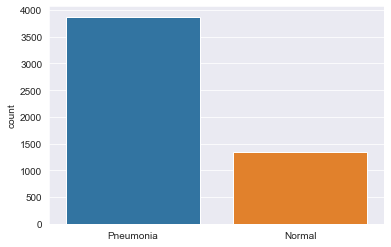

In [21]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

The data are  imbalanced . We will use data augmentation in order to overcome the problem 

Text(0.5, 1.0, 'NORMAL')

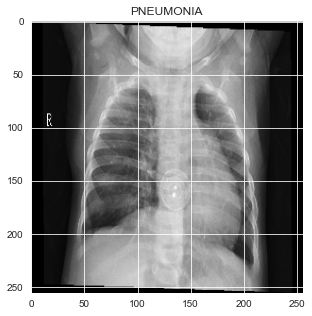

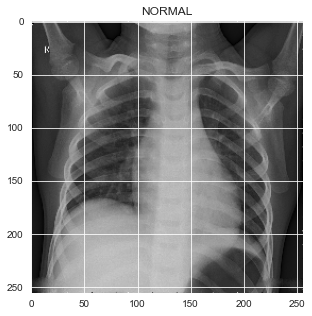

In [34]:
plt.figure(figsize = (5,5))
plt.imshow(train[10][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [23]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [24]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

##### Data Augmentation 



In [40]:
# With data augmentation we try to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(x_train)

In [42]:
# Model Architecture 

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 38, 38, 64)       

In [36]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.3, min_lr=0.00001)

In [58]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 15 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/15
163/163 [==============================] - 15s 92ms/step - loss: 0.0986 - accuracy: 0.9626 - val_loss: 0.5104 - val_accuracy: 0.7500
Epoch 2/15
163/163 [==============================] - 16s 101ms/step - loss: 0.0954 - accuracy: 0.9653 - val_loss: 0.3572 - val_accuracy: 0.6875
Epoch 3/15
163/163 [==============================] - 17s 101ms/step - loss: 0.0987 - accuracy: 0.9632 - val_loss: 0.7248 - val_accuracy: 0.7500
Epoch 4/15
163/163 [==============================] - 17s 105ms/step - loss: 0.1033 - accuracy: 0.9638 - val_loss: 0.2964 - val_accuracy: 0.8125
Epoch 5/15
163/163 [==============================] - 17s 104ms/step - loss: 0.1052 - accuracy: 0.9622 - val_loss: 0.4945 - val_accuracy: 0.8125
Epoch 6/15
163/163 [==============================] - 17s 104ms/step - loss: 0.1048 - accuracy: 0.9620 - val_loss: 0.7991 - val_accuracy: 0.7500
Epoch 7/15
163/163 [==============================] - 17s 104ms/step - loss: 0.0977 - accuracy: 0.9640 - val_loss: 0.7796 - val_acc

### Plot the results 

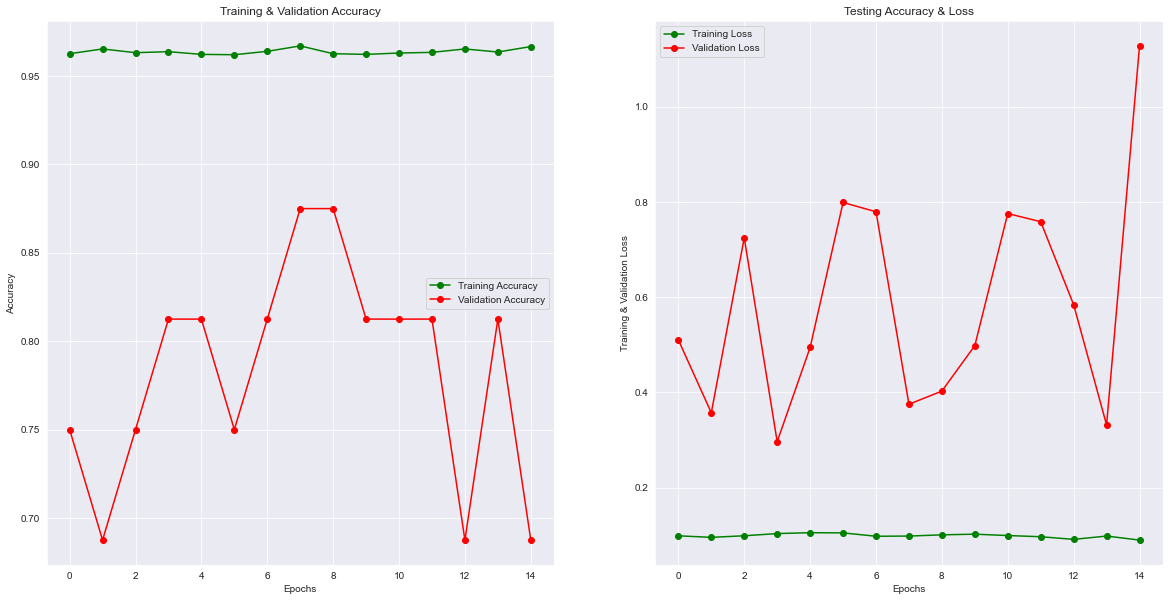

In [59]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [60]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]


print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))



C:\Users\Tsaro\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.97      0.91       390
   Normal (Class 1)       0.94      0.73      0.82       234

           accuracy                           0.88       624
          macro avg       0.90      0.85      0.87       624
       weighted avg       0.89      0.88      0.88       624



<AxesSubplot:>

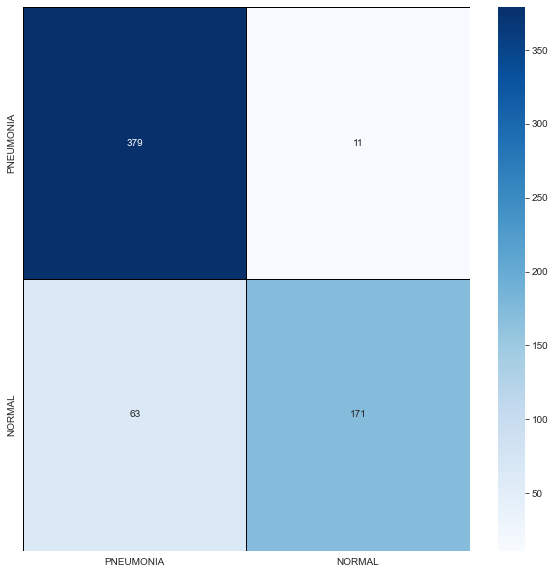

In [61]:
cm = confusion_matrix(y_test,predictions)

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [48]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

#### Plot some correct results

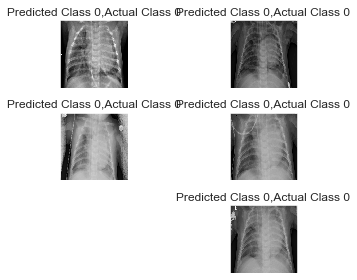

In [50]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### Plot some incorrect results 

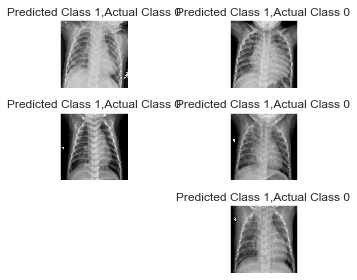

In [51]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1